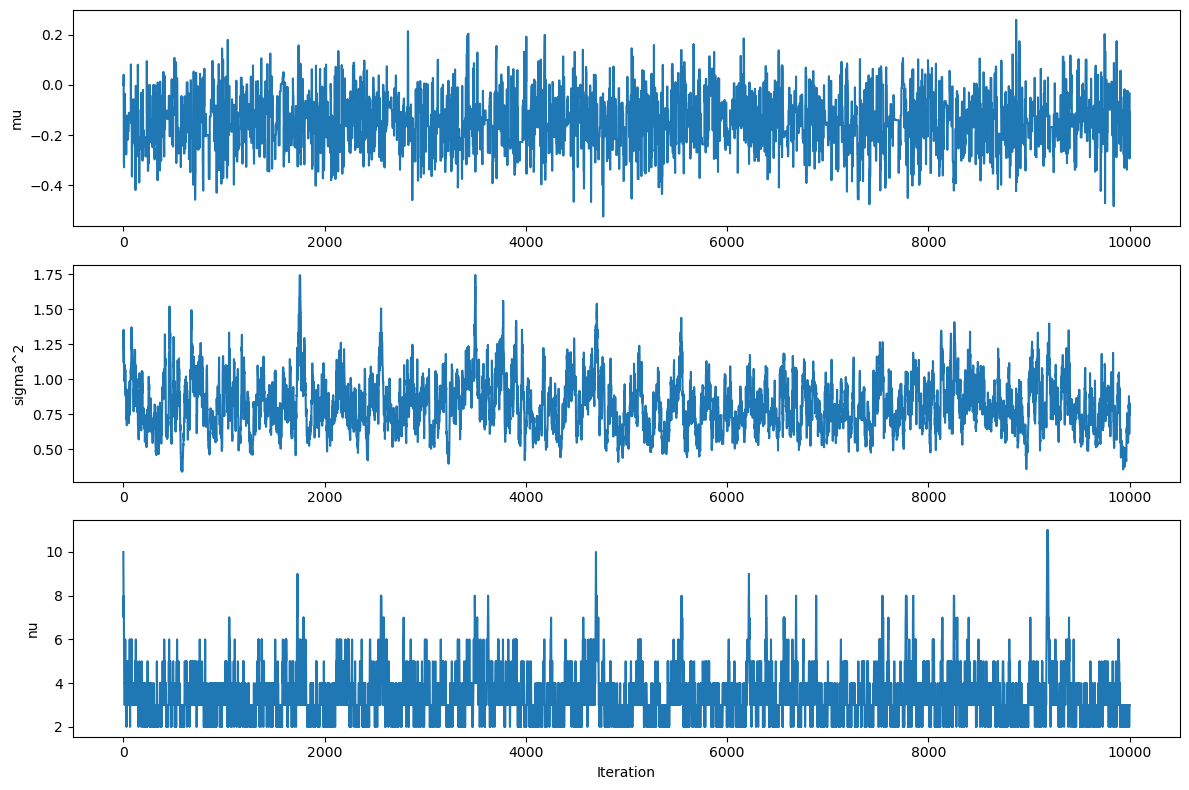

In [1]:
# Q1 

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

np.random.seed(42)
n = 100
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5
x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

mu0 = 0.0
tau0 = 1.0
sigma0 = 1.0

def log_post(mu, sigma2, nu, x, mu0, tau0, sigma0):
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf
    ll = np.sum(gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(np.pi*nu*sigma2) - ((nu+1)/2)*np.log(1 + ((x-mu)**2)/(nu*sigma2)))
    lp_mu = 0.5*np.log(tau0/(2*np.pi)) - (tau0/2)*(mu - mu0)**2
    lp_sigma2 = 0.5*np.log(2/(np.pi*sigma0**2)) - (sigma2**2)/(2*sigma0**2)
    lp_nu = -np.log(100)
    return ll + lp_mu + lp_sigma2 + lp_nu

iters = 10000
mu_samples = np.zeros(iters)
sigma2_samples = np.zeros(iters)
nu_samples = np.zeros(iters, dtype=int)

mu_current = 0.0
sigma2_current = 1.0
nu_current = 10
log_post_current = log_post(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

mu_prop_sd = 0.5
log_sigma2_prop_sd = 0.1

for t in range(iters):
    mu_proposal = mu_current + np.random.normal(0, mu_prop_sd)
    log_post_proposal = log_post(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        mu_current = mu_proposal
        log_post_current = log_post_proposal
    mu_samples[t] = mu_current

    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    log_post_proposal = log_post(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current + log_sigma2_proposal - log_sigma2_current:
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal
    sigma2_samples[t] = sigma2_current

    nu_proposal = nu_current + np.random.choice([-1, 1])
    if nu_proposal < 1:
        nu_proposal = 1
    if nu_proposal > 100:
        nu_proposal = 100
    log_post_proposal = log_post(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        nu_current = nu_proposal
        log_post_current = log_post_proposal
    nu_samples[t] = nu_current

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(mu_samples)
plt.ylabel("mu")
plt.subplot(3,1,2)
plt.plot(sigma2_samples)
plt.ylabel("sigma^2")
plt.subplot(3,1,3)
plt.plot(nu_samples)
plt.ylabel("nu")
plt.xlabel("Iteration")
plt.tight_layout()
plt.show()

In [3]:
# Q2

import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

np.random.seed(42)
sample_sizes = [50, 100, 500, 1000]
true_mu = 0.0
true_sigma = 1.0
true_nu = 5
results = {}

for n in sample_sizes:
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)
    with pm.Model() as model:
        mu = pm.Normal("mu", mu=0, sigma=5)
        sigma = pm.HalfNormal("sigma", sigma=1)
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)
        idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)
    results[n] = idata

for n in sample_sizes:
    print("Sample size:", n)
    print(az.summary(results[n], var_names=["nu"]))

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigma]
>Metropolis: [nu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sample size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  54.126  26.703    10.0     98.0      0.893    0.632     888.0     978.0   

    r_hat  
nu    1.0  
Sample size: 100
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  2.214  0.608     1.0      3.0      0.031    0.022     364.0     342.0   

    r_hat  
nu    1.0  
Sample size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.564  2.888     4.0     12.0      0.205    0.145     197.0     200.0   

    r_hat  
nu   1.01  
Sample size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  7.274  1.654     5.0     10.0      0.083    0.059     351.0     266.0   

    r_hat  
nu   1.02  
